In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import math
import xgboost as xgb
import toad
# 加载数据
data_all = pd.read_csv("../data/scorecard.txt")

# 指定不参与训练列名
ex_lis = ['uid', 'samp_type', 'bad_ind']
# 参与训练列名
ft_lis = list(data_all.columns)
for i in ex_lis:
    ft_lis.remove(i)

# 开发样本、验证样本与时间外样本
dev = data_all[(data_all['samp_type'] == 'dev')]
val = data_all[(data_all['samp_type'] == 'val') ]
off = data_all[(data_all['samp_type'] == 'off') ]

* EDA探索性数据分析

In [3]:
data_all['samp_type'].value_counts()

dev    65304
off    15975
val    14527
Name: samp_type, dtype: int64

In [4]:
data_all.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95806 entries, 0 to 95805
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bad_ind       95806 non-null  float64
 1   uid           95806 non-null  object 
 2   td_score      95806 non-null  float64
 3   jxl_score     95806 non-null  float64
 4   mj_score      95806 non-null  float64
 5   rh_score      95806 non-null  float64
 6   zzc_score     95806 non-null  float64
 7   zcx_score     95806 non-null  float64
 8   person_info   95806 non-null  float64
 9   finance_info  95806 non-null  float64
 10  credit_info   95806 non-null  float64
 11  act_info      95806 non-null  float64
 12  samp_type     95806 non-null  object 
dtypes: float64(11), object(2)
memory usage: 9.5+ MB


In [5]:
toad.detector.detect(data_all)


,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
bad_ind,float64,95806,0.00%,2,0.018767,0.135702,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
uid,object,95806,0.00%,95806,A685577:0.00%,Ab99_96436390964255168:0.00%,A3748687:0.00%,A7054839:0.00%,A13607126:0.00%,A2789290:0.00%,A8458963:0.00%,A4252783:0.00%,A14171687:0.00%,A1347613:0.00%
td_score,float64,95806,0.00%,95806,0.499739,0.288349,0.000005,0.009613,0.099706,0.500719,0.747984,0.900024,0.990041,0.999999
jxl_score,float64,95806,0.00%,95806,0.499338,0.28885,0.000013,0.009947,0.099103,0.499795,0.748646,0.899703,0.989348,0.999985
mj_score,float64,95806,0.00%,95806,0.50164,0.288679,0.000007,0.010508,0.100882,0.503048,0.752032,0.899308,0.990047,0.999993
rh_score,float64,95806,0.00%,95806,0.498407,0.287797,0.000005,0.009916,0.099948,0.497466,0.747188,0.899286,0.989473,0.999986
zzc_score,float64,95806,0.00%,95806,0.500627,0.289067,0.000012,0.010186,0.099011,0.501688,0.750986,0.899924,0.990043,0.999998
zcx_score,float64,95806,0.00%,95806,0.499672,0.289137,0.00001,0.010325,0.099743,0.49913,0.750683,0.901942,0.989712,0.999987
person_info,float64,95806,0.00%,7,-0.078229,0.156859,-0.322581,-0.322581,-0.322581,-0.053718,0.078853,0.078853,0.078853,0.078853
finance_info,float64,95806,0.00%,35,0.036763,0.039687,0.02381,0.02381,0.02381,0.02381,0.02381,0.071429,0.214286,1.02381


In [7]:
#dev_slct1：留下的数据
#drop_lst：删除的特征
dev_slct1, drop_lst= toad.selection.select(dev, dev['bad_ind'],
                                                   empty=0.7, iv=0.03,
                                                   corr=0.7,
                                                   return_drop=True,
                                                   exclude=ex_lis)

In [8]:
dev_slct1


,bad_ind,uid,td_score,jxl_score,mj_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info,samp_type
0,0.0,A1000002,0.825269,0.398688,0.139396,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077,dev
1,0.0,A1000011,0.315406,0.629745,0.535854,0.614416,0.320731,0.062660,0.023810,0.10,0.448718,dev
2,0.0,A10000481,0.002386,0.609360,0.366081,0.870006,0.288692,0.078853,0.071429,0.05,0.179487,dev
3,0.0,A1000069,0.406310,0.405352,0.783015,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077,dev
4,0.0,A10001225,0.919365,0.783020,0.033548,0.544368,0.137676,0.013863,0.023810,0.50,0.166667,dev
...,...,...,...,...,...,...,...,...,...,...,...,...
65299,0.0,Ab99_96436391994279078,0.864104,0.809891,0.712161,0.040651,0.971456,0.078853,0.023810,0.03,0.076923,dev
65300,0.0,Ab99_96436391998556194,0.893096,0.079603,0.834487,0.890714,0.896967,0.078853,0.142857,1.00,0.076923,dev
65301,0.0,Ab99_96436391999814360,0.234014,0.565962,0.532120,0.974988,0.348905,0.078853,0.095238,0.04,0.076923,dev
65302,0.0,Ab99_96436392001777095,0.027324,0.732346,0.084060,0.127223,0.274230,0.078853,0.023810,0.00,0.076923,dev


In [9]:
drop_lst


{'empty': array([], dtype=float64),
 'iv': array(['rh_score'], dtype=object),
 'corr': array([], dtype=object)}

In [11]:
print("keep:", dev_slct1.shape[1],
      "drop empty:", len(drop_lst['empty']),
      "drop iv:", len(drop_lst['iv']),
      "drop corr:", len(drop_lst['corr']))


keep: 12 drop empty: 0 drop iv: 1 drop corr: 0


* 分箱


In [12]:
# 得到切分节点
combiner = toad.transform.Combiner()
combiner.fit(dev_slct1, dev_slct1['bad_ind'], method='chi',
                min_samples=0.05, exclude=ex_lis)
# 导出箱的节点
bins = combiner.export()
print(bins)

{'td_score': [0.7989831262724624], 'jxl_score': [0.4197048501965005], 'mj_score': [0.3615303943747963], 'zzc_score': [0.4469861520889339], 'zcx_score': [0.7007847486465795], 'person_info': [-0.2610139784946237, -0.1286774193548387, -0.0537175627240143, 0.013863440860215, 0.0626602150537634, 0.078853046594982], 'finance_info': [0.0476190476190476], 'credit_info': [0.02, 0.04, 0.11], 'act_info': [0.1153846153846154, 0.141025641025641, 0.1666666666666666, 0.2051282051282051, 0.2692307692307692, 0.358974358974359, 0.3974358974358974, 0.5256410256410257]}


In [13]:
bins

{'td_score': [0.7989831262724624],
 'jxl_score': [0.4197048501965005],
 'mj_score': [0.3615303943747963],
 'zzc_score': [0.4469861520889339],
 'zcx_score': [0.7007847486465795],
 'person_info': [-0.2610139784946237,
  -0.1286774193548387,
  -0.0537175627240143,
  0.013863440860215,
  0.0626602150537634,
  0.078853046594982],
 'finance_info': [0.0476190476190476],
 'credit_info': [0.02, 0.04, 0.11],
 'act_info': [0.1153846153846154,
  0.141025641025641,
  0.1666666666666666,
  0.2051282051282051,
  0.2692307692307692,
  0.358974358974359,
  0.3974358974358974,
  0.5256410256410257]}

<AxesSubplot:xlabel='act_info', ylabel='prop'>

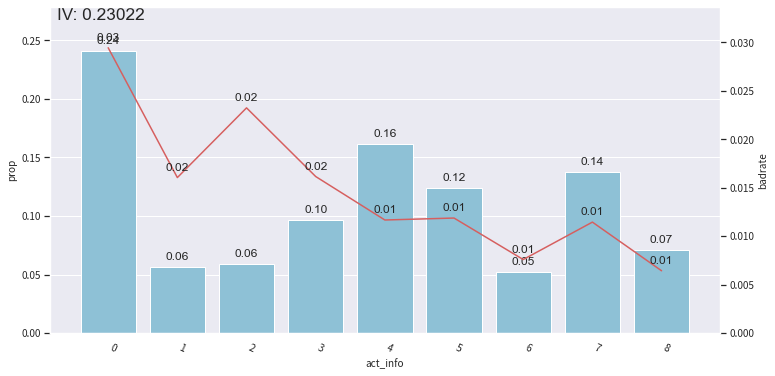

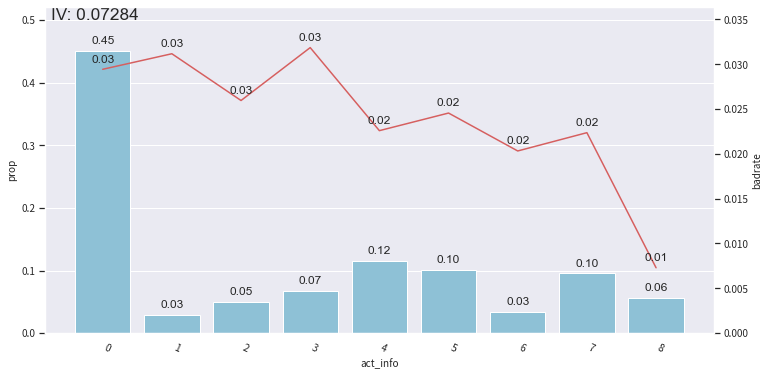

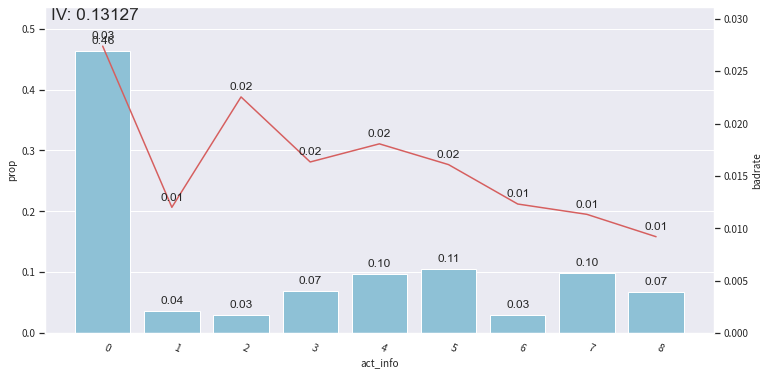

In [14]:
# 根据节点实施分箱
dev_slct2 = combiner.transform(dev_slct1)
val2 = combiner.transform(val[dev_slct1.columns])
off2 = combiner.transform(off[dev_slct1.columns])
# 分箱后通过画图观察
from toad.plot import  bin_plot, badrate_plot
bin_plot(dev_slct2, x='act_info', target='bad_ind')
bin_plot(val2, x='act_info', target='bad_ind')
bin_plot(off2, x='act_info', target='bad_ind')


<AxesSubplot:xlabel='act_info', ylabel='prop'>

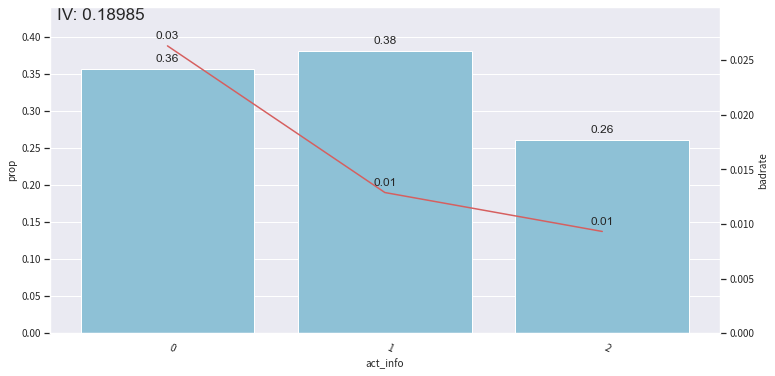

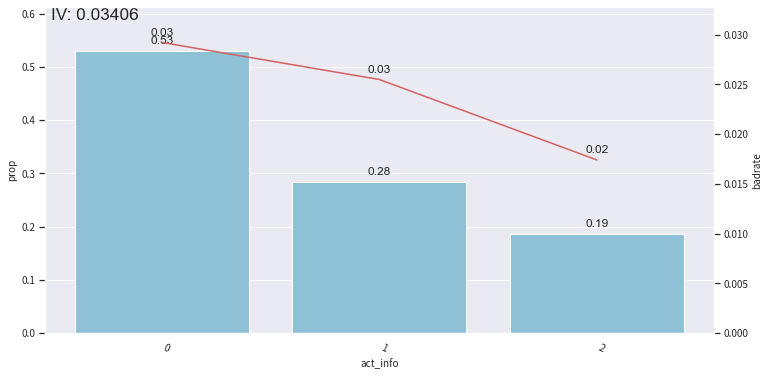

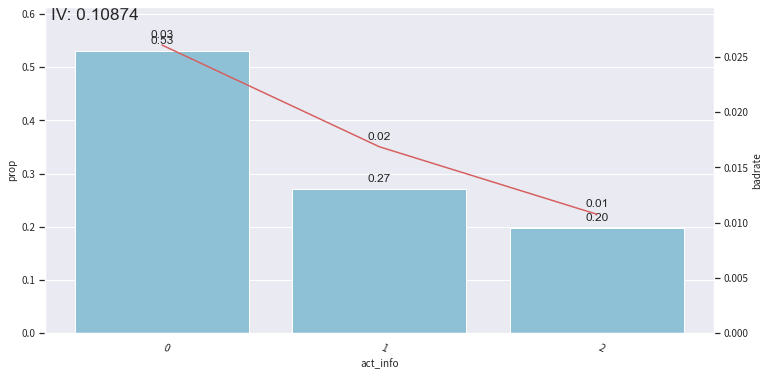

In [15]:
#通过手动设置分箱边界值来调整分箱
adj_bin = {'act_info': [0.1666666666666666,0.358974358974359]}
combiner.set_rules(adj_bin)

dev_slct3 = combiner.transform(dev_slct1)
val3 = combiner.transform(val[dev_slct1.columns])
off3 = combiner.transform(off[dev_slct1.columns])

# 画出Bivar图
bin_plot(dev_slct3, x='act_info', target='bad_ind')
bin_plot(val3, x='act_info', target='bad_ind')
bin_plot(off3, x='act_info', target='bad_ind')

<AxesSubplot:xlabel='samp_type', ylabel='badrate'>

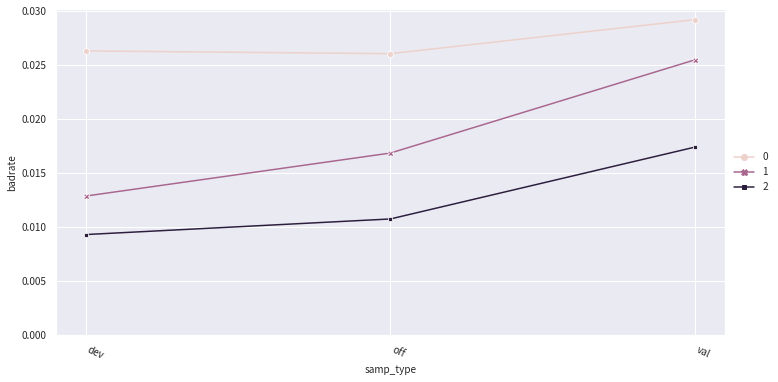

In [17]:
data = pd.concat([dev_slct3,val3,off3], join='inner')
badrate_plot(data, x='samp_type', target='bad_ind', by='act_info')


<AxesSubplot:xlabel='samp_type', ylabel='badrate'>

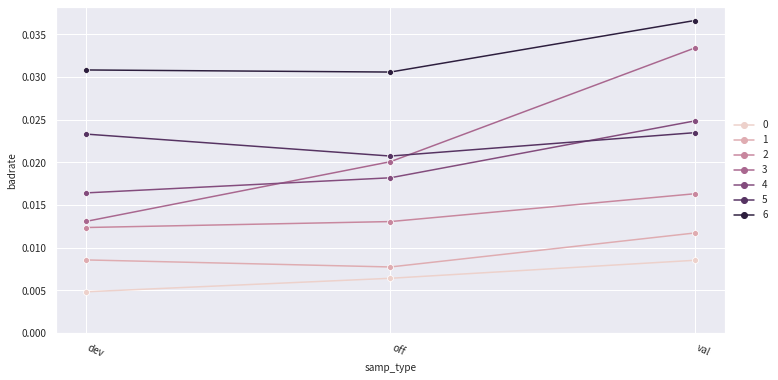

In [19]:
#查看person_info字段的坏样本占比率图
data = pd.concat([dev_slct3,val3,off3], join='inner')
badrate_plot(data, x='samp_type', target='bad_ind', by='person_info')

* WOE编码


In [20]:
t = toad.transform.WOETransformer()
dev_slct3_woe = t.fit_transform(dev_slct3, dev_slct3['bad_ind'],
                                      exclude=ex_lis)
val_woe = t.transform(val3[dev_slct3.columns])
off_woe = t.transform(off3[dev_slct3.columns])
data = pd.concat([dev_slct3_woe, val_woe, off_woe])

In [21]:
data


,bad_ind,uid,td_score,jxl_score,mj_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info,samp_type
0,0.0,A1000002,-0.000706,-0.029581,0.033478,0.018550,-0.052176,-0.306411,-0.607329,-0.822677,-0.593981,dev
1,0.0,A1000011,0.000176,0.020754,-0.019345,0.018550,-0.052176,0.338661,-0.607329,0.556362,-0.593981,dev
2,0.0,A10000481,0.000176,0.020754,-0.019345,0.018550,-0.052176,0.625661,1.283319,0.556362,-0.266137,dev
3,0.0,A1000069,0.000176,-0.029581,-0.019345,0.018550,-0.052176,-0.676743,-0.607329,-0.822677,-0.593981,dev
4,0.0,A10001225,-0.000706,0.020754,0.033478,0.018550,-0.052176,-0.018649,-0.607329,1.047570,-0.266137,dev
...,...,...,...,...,...,...,...,...,...,...,...,...
95801,0.0,Ab99_96436391998107976,-0.000706,0.020754,-0.019345,0.018550,-0.052176,0.625661,1.283319,1.047570,0.462154,off
95802,0.0,Ab99_96436391998176292,0.000176,0.020754,0.033478,0.018550,-0.052176,0.625661,-0.607329,-0.822677,0.462154,off
95803,0.0,Ab99_96436391998322771,0.000176,0.020754,0.033478,0.018550,-0.052176,0.625661,-0.607329,-0.822677,0.462154,off
95804,0.0,Ab99_96436391998973383,0.000176,0.020754,-0.019345,0.018550,0.112487,0.625661,-0.607329,-0.240169,0.462154,off


In [22]:
psi_df = toad.metrics.PSI(dev_slct3_woe, val_woe).sort_values()
psi_df


uid             0.000000e+00
samp_type       0.000000e+00
td_score        8.778656e-07
zcx_score       4.183912e-06
jxl_score       2.901553e-05
zzc_score       3.764148e-05
mj_score        5.005908e-05
bad_ind         4.128345e-03
credit_info     9.489392e-02
act_info        1.237395e-01
person_info     1.278102e-01
finance_info    1.341445e-01
dtype: float64

In [23]:
#根据稳定性，删除比较大的值（>0.13，随机给的）
psi_columns = psi_df[psi_df<0.13].index.to_list()
dev_woe_psi = dev_slct3_woe[psi_columns]
val_woe_psi = val_woe[psi_columns]
off_woe_psi = off_woe[psi_columns]


In [24]:
psi_columns


['uid',
 'samp_type',
 'td_score',
 'zcx_score',
 'jxl_score',
 'zzc_score',
 'mj_score',
 'bad_ind',
 'credit_info',
 'act_info',
 'person_info']

In [26]:
dev_woe_psi2, drop_lst = toad.selection.select(dev_woe_psi,
                                               dev_woe_psi['bad_ind'],
                                               empty=0.6,
                                               iv=0.001,
                                               corr=0.5,
                                               return_drop=True,
                                               exclude=ex_lis)


In [27]:
dev_woe_psi2


,uid,samp_type,zcx_score,bad_ind,credit_info,act_info,person_info
0,A1000002,dev,-0.052176,0.0,-0.822677,-0.593981,-0.306411
1,A1000011,dev,-0.052176,0.0,0.556362,-0.593981,0.338661
2,A10000481,dev,-0.052176,0.0,0.556362,-0.266137,0.625661
3,A1000069,dev,-0.052176,0.0,-0.822677,-0.593981,-0.676743
4,A10001225,dev,-0.052176,0.0,1.047570,-0.266137,-0.018649
...,...,...,...,...,...,...,...
65299,Ab99_96436391994279078,dev,0.112487,0.0,-0.240169,0.462154,0.625661
65300,Ab99_96436391998556194,dev,0.112487,0.0,1.047570,0.462154,0.625661
65301,Ab99_96436391999814360,dev,-0.052176,0.0,0.556362,0.462154,0.625661
65302,Ab99_96436392001777095,dev,-0.052176,0.0,-0.822677,0.462154,0.625661


In [28]:
drop_lst


{'empty': array([], dtype=float64),
 'iv': array(['td_score', 'jxl_score', 'zzc_score', 'mj_score'], dtype=object),
 'corr': array([], dtype=object)}

* 使用stepwise进行特征选择


In [30]:
#direction：双向进行筛选，推荐值
#criterion：评价指标：ks
#estimator：lr，逻辑回归
dev_woe_psi_stp = toad.selection.stepwise(dev_woe_psi2,
                                                  dev_woe_psi2['bad_ind'],
                                                  exclude=ex_lis,
                                                  direction='both',
                                                  criterion='ks',
                                                  estimator='lr',
                                              intercept=False)
val_woe_psi_stp = val_woe_psi[dev_woe_psi_stp.columns]
off_woe_psi_stp = off_woe_psi[dev_woe_psi_stp.columns]
data = pd.concat([dev_woe_psi_stp, val_woe_psi_stp, off_woe_psi_stp])
print(data.shape)

(95806, 6)


In [31]:
data


,uid,samp_type,bad_ind,credit_info,act_info,person_info
0,A1000002,dev,0.0,-0.822677,-0.593981,-0.306411
1,A1000011,dev,0.0,0.556362,-0.593981,0.338661
2,A10000481,dev,0.0,0.556362,-0.266137,0.625661
3,A1000069,dev,0.0,-0.822677,-0.593981,-0.676743
4,A10001225,dev,0.0,1.047570,-0.266137,-0.018649
...,...,...,...,...,...,...
95801,Ab99_96436391998107976,off,0.0,1.047570,0.462154,0.625661
95802,Ab99_96436391998176292,off,0.0,-0.822677,0.462154,0.625661
95803,Ab99_96436391998322771,off,0.0,-0.822677,0.462154,0.625661
95804,Ab99_96436391998973383,off,0.0,-0.240169,0.462154,0.625661


* 模型训练


In [33]:
# 模型训练 分别使用 逻辑回归 和 XGBoost 训练评分卡模型
# 在银行往往还在使用lr  XGB可以作为陪跑模型, 看lr效果是否还有提升空间
# XGB作为线上模型  训练一个逻辑回归 可以提供模型的可解释性
def lr_model(x, y, valx, valy, offx, offy, C):
    model = LogisticRegression(C=C, class_weight='balanced')
    model.fit(x,y)

    y_pred = model.predict_proba(x)[:,1]
    fpr_dev,tpr_dev,_ = roc_curve(y, y_pred)
    train_ks = abs(fpr_dev - tpr_dev).max()
    print('train_ks : ', train_ks)

    y_pred = model.predict_proba(valx)[:,1]
    fpr_val,tpr_val,_ = roc_curve(valy, y_pred)
    val_ks = abs(fpr_val - tpr_val).max()
    print('val_ks : ', val_ks)

    y_pred = model.predict_proba(offx)[:,1]
    fpr_off,tpr_off,_ = roc_curve(offy, y_pred)
    off_ks = abs(fpr_off - tpr_off).max()
    print('off_ks : ', off_ks)

    from matplotlib import pyplot as plt
    plt.plot(fpr_dev, tpr_dev, label='dev')
    plt.plot(fpr_val, tpr_val, label='val')
    plt.plot(fpr_off, tpr_off, label='off')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()



def xgb_model(x, y, valx, valy, offx, offy):
    model = xgb.XGBClassifier(learning_rate=0.05,
                              n_estimators=400,
                              max_depth=2,
                              class_weight='balanced',
                              min_child_weight=1,
                              subsample=1,
                              nthread=-1,
                              scale_pos_weight=1,
                              random_state=1,
                              n_jobs=-1,
                              reg_lambda=300)
    model.fit(x, y)

    y_pred = model.predict_proba(x)[:,1]
    fpr_dev,tpr_dev,_ = roc_curve(y, y_pred)
    train_ks = abs(fpr_dev - tpr_dev).max()
    print('train_ks : ', train_ks)

    y_pred = model.predict_proba(valx)[:,1]
    fpr_val,tpr_val,_ = roc_curve(valy, y_pred)
    val_ks = abs(fpr_val - tpr_val).max()
    print('val_ks : ', val_ks)

    y_pred = model.predict_proba(offx)[:,1]
    fpr_off,tpr_off,_ = roc_curve(offy, y_pred)
    off_ks = abs(fpr_off - tpr_off).max()
    print('off_ks : ', off_ks)

    from matplotlib import pyplot as plt
    plt.plot(fpr_dev, tpr_dev, label='dev')
    plt.plot(fpr_val, tpr_val, label='val')
    plt.plot(fpr_off, tpr_off, label='off')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

In [35]:
def bi_train(data, dep='bad_ind', exclude=None):
    from sklearn.preprocessing import StandardScaler
    std_scaler = StandardScaler()
    # 变量名
    lis = list(data.columns)
    for i in exclude:
        lis.remove(i)
    devv = data[(data['samp_type']=='dev')]
    vall = data[(data['samp_type']=='val')]
    offf = data[(data['samp_type']=='off')]
    x, y = devv[lis], devv[dep]
    valx, valy = vall[lis], vall[dep]
    offx, offy = offf[lis], offf[dep]
    # 逻辑回归正向
    print("逻辑回归正向：")
    lr_model(x, y, valx, valy, offx, offy, 0.1)
    # 逻辑回归反向
    print("逻辑回归反向：")
    lr_model(offx, offy, valx, valy, x, y, 0.1)
    # XGBoost正向
    print("XGBoost正向：")
    xgb_model(x, y, valx, valy, offx, offy)
    # XGBoost反向
    print("XGBoost反向：")
    xgb_model(offx, offy, valx, valy, x, y)


逻辑回归正向：
train_ks :  0.41733648227995124
val_ks :  0.3593935758405114
off_ks :  0.3758086175640308


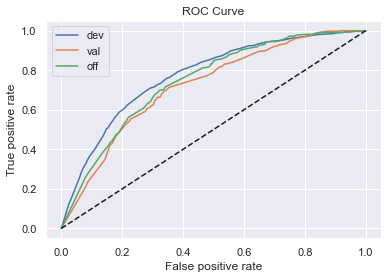

逻辑回归反向：
train_ks :  0.3892612859630226
val_ks :  0.3717891855920369
off_ks :  0.4061965880072622


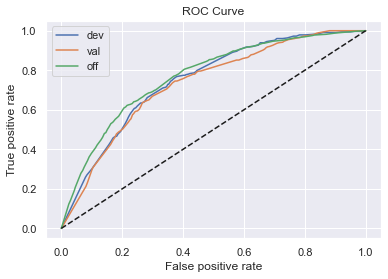

XGBoost正向：


C:\Programming\Anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [18:05:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


train_ks :  0.42521927400747045
val_ks :  0.3595542266920359
off_ks :  0.37437103192850807


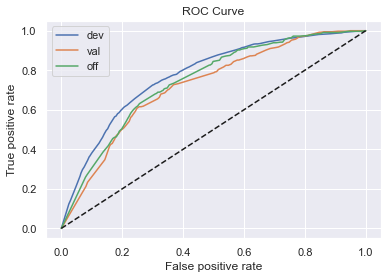

XGBoost反向：
train_ks :  0.3939473708822855


C:\Programming\Anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [18:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


val_ks :  0.3799497614606668
off_ks :  0.40023425741725266


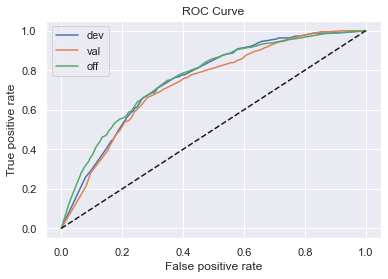

In [36]:
bi_train(data, dep='bad_ind', exclude=ex_lis)


In [38]:
dep = 'bad_ind'
lis = list(data.columns)
for i in ex_lis:
    lis.remove(i)
devv = data[data['samp_type']=='dev']
vall = data[data['samp_type']=='val']
offf = data[data['samp_type']=='off' ]
x, y = devv[lis], devv[dep]
valx, valy = vall[lis], vall[dep]
offx, offy = offf[lis], offf[dep]
lr = LogisticRegression()
lr.fit(x, y)


LogisticRegression()

In [40]:
from toad.metrics import KS, F1, AUC

prob_dev = lr.predict_proba(x)[:,1]
print('训练集')
print('F1:', F1(prob_dev,y))
print('KS:', KS(prob_dev,y))
print('AUC:', AUC(prob_dev,y))

prob_val = lr.predict_proba(valx)[:,1]
print('验证集')
print('F1:', F1(prob_val,valy))
print('KS:', KS(prob_val,valy))
print('AUC:', AUC(prob_val,valy))

prob_off = lr.predict_proba(offx)[:,1]
print('时间外样本')
print('F1:', F1(prob_off,offy))
print('KS:', KS(prob_off,offy))
print('AUC:', AUC(prob_off,offy))

print('模型PSI:',toad.metrics.PSI(prob_dev,prob_off))
print('特征PSI:','\n',toad.metrics.PSI(x,offx).sort_values(0))

验证集
F1: 0.027689429373246022
KS: 0.36127808343721585
AUC: 0.7225727568398459
时间外样本
F1: 0.032454090150250414
KS: 0.3807135163445966
AUC: 0.7435613582904539
模型PSI: 0.34091667386100255
特征PSI: 
 credit_info    0.098585
act_info       0.124820
person_info    0.127833
dtype: float64
训练集
F1: 0.02962459026532253
KS: 0.41406129833591426
AUC: 0.7713247123864264
验证集
F1: 0.027689429373246022
KS: 0.36127808343721585
AUC: 0.7225727568398459
时间外样本
F1: 0.032454090150250414
KS: 0.3807135163445966
AUC: 0.7435613582904539
模型PSI: 0.34091667386100255
特征PSI: 
 credit_info    0.098585
act_info       0.124820
person_info    0.127833
dtype: float64


* 模型报告

In [41]:
#模型报告
toad.metrics.KS_bucket(prob_off,offy,
                       bucket=15,
                       method='quantile')

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,...,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,0.001877,0.003199,2.0,963.0,965.0,0.002073,0.997927,0.002077,0.006098,0.061545,...,0.020532,0.006098,1.000000,0.061545,1.000000,0.060407,1.000000,0.055448,0.100941,1.000000
1,0.003799,0.004080,1.0,1054.0,1055.0,0.000948,0.999052,0.000949,0.003049,0.067361,...,0.021719,0.009146,0.993902,0.128906,0.938455,0.126448,0.939593,0.119760,0.046165,1.057801
2,0.004275,0.005393,3.0,793.0,796.0,0.003769,0.996231,0.003783,0.009146,0.050681,...,0.023289,0.018293,0.990854,0.179587,0.871094,0.176275,0.873552,0.161294,0.183559,1.134281
3,0.006364,0.008345,7.0,1341.0,1348.0,0.005193,0.994807,0.005220,0.021341,0.085703,...,0.024470,0.039634,0.981707,0.265290,0.820413,0.260657,0.823725,0.225656,0.252915,1.191791
4,0.008612,0.008781,6.0,958.0,964.0,0.006224,0.993776,0.006263,0.018293,0.061226,...,0.026670,0.057927,0.960366,0.326516,0.734710,0.321002,0.739343,0.268589,0.303139,1.298945
5,0.009022,0.010888,9.0,799.0,808.0,0.011139,0.988861,0.011264,0.027439,0.051064,...,0.028487,0.085366,0.942073,0.377580,0.673484,0.371581,0.678998,0.292215,0.542498,1.387445
6,0.011017,0.014789,17.0,1464.0,1481.0,0.011479,0.988521,0.011612,0.051829,0.093564,...,0.029883,0.137195,0.914634,0.471145,0.622420,0.464288,0.628419,0.333950,0.559063,1.455452
7,0.014831,0.018065,10.0,581.0,591.0,0.016920,0.983080,0.017212,0.030488,0.037132,...,0.033068,0.167683,0.862805,0.508276,0.528855,0.501283,0.535712,0.340593,0.824099,1.610576
8,0.018363,0.022194,44.0,2571.0,2615.0,0.016826,0.983174,0.017114,0.134146,0.164313,...,0.034266,0.301829,0.832317,0.672589,0.491724,0.664977,0.498717,0.370760,0.819498,1.668917
9,0.022277,0.030317,26.0,798.0,824.0,0.031553,0.968447,0.032581,0.079268,0.051000,...,0.042788,0.381098,0.698171,0.723589,0.327411,0.716557,0.335023,0.342492,1.536785,2.083946


In [43]:
from toad.scorecard import ScoreCard
card = ScoreCard(combiner=combiner,
                    transer=t, C=0.1,
                    class_weight='balanced',
                    base_score=750,
                    base_odds=20,
                    pdo=60,
                    rate=2)
card.fit(x,y)
final_card = card.export(to_frame=True)
final_card


,name,value,score
0,credit_info,[-inf ~ 0.02),231.82
1,credit_info,[0.02 ~ 0.04),183.49
2,credit_info,[0.04 ~ 0.11),117.40
3,credit_info,[0.11 ~ inf),76.64
4,act_info,[-inf ~ 0.1666666666666666),132.82
5,act_info,[0.1666666666666666 ~ 0.358974358974359),181.26
6,act_info,[0.358974358974359 ~ inf),203.07
7,person_info,[-inf ~ -0.2610139784946237),260.44
8,person_info,[-0.2610139784946237 ~ -0.1286774193548387),215.90
9,person_info,[-0.1286774193548387 ~ -0.0537175627240143),187.26
